In [1]:
import os
import numpy as np
#%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()

import Corrfunc

from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.theory.DD import DD
from Corrfunc.theory.xi import xi
from Corrfunc.utils import compute_amps
from Corrfunc.utils import evaluate_xi
from Corrfunc.utils import qq_analytic
from Corrfunc.bases import spline

%load_ext autoreload
%autoreload 2

# Tophat on theory data

### Set up parameters

Here we use a low-density lognormal simulation box.

In [2]:
boxsize = 750
nbar_str = '1e-5'
proj_type = 'tophat'
#proj_type = None

rmin = 40
rmax = 200
nbins = 16

mumax = 1.0
seed = 0
#weight_type='pair_product'
weight_type=None

In [3]:
rbins = np.linspace(rmin, rmax, nbins+1)
rbins_avg = 0.5*(rbins[1:]+rbins[:-1])
rcont = np.linspace(rmin, rmax, 1000)

cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
cat_dir = '../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag)

periodic = False
nthreads = 24
nmubins = 1
verbose = False

### Load in data and randoms

In [4]:
# data
data_fn = '{}/cat_lognormal{}_seed{}.dat'.format(cat_dir, cat_tag, seed)
data = np.loadtxt(data_fn)
x, y, z = data.T
nd = data.shape[0]
#weights = np.full(nd, 0.5)
weights = None

In [5]:
# randoms
rand_fn = '{}/rand{}_10x.dat'.format(cat_dir, cat_tag)
random = np.loadtxt(rand_fn)
x_rand, y_rand, z_rand = random.T
nr = random.shape[0]
#weights_rand = np.full(nr, 0.5)
weights_rand = None

In [6]:
def extract_counts(res, weight_type=None, col=4):
    counts = np.array([x[col] for x in res], dtype=float)
    if weight_type:
        weights = np.array([x[5] for x in res], dtype=float)
        counts *= weights
    return counts

### 3D correlation function

Here we will compute the 3D correlation function, xi(r). We will use DD(s, mu) with a single mu bin up to mu_max = 1, so this is equivalent to DD(r). Check:

In [10]:
ddsmu_res, _, _ = DDsmu(1, nthreads, rbins, mumax, nmubins, x, y, z, boxsize=boxsize, periodic=True)
ddsmu = extract_counts(ddsmu_res)
print(ddsmu)
dd_res = DD(1, nthreads, rbins, x, y, z, boxsize=boxsize, periodic=True)
dd = extract_counts(dd_res, col=3)
print(dd)

[ 11012.  16560.  22158.  29640.  38270.  47410.  57808.  70030.  83316.
  97308. 111502.]
[ 11012.  16560.  22158.  29640.  38270.  47410.  57808.  70030.  83316.
  97308. 111502.]


### Perform xi(s, mu) continous estimation

In [11]:
# projection
_, dd_proj, _ = DDsmu(1, nthreads, rbins, mumax, nmubins, x, y, z,
                proj_type=proj_type, nprojbins=nbins,
                verbose=verbose, boxsize=boxsize, periodic=periodic)

_, dr_proj, _ = DDsmu(0, nthreads, rbins, mumax, nmubins, 
                x, y, z, X2=x_rand, Y2=y_rand, Z2=z_rand, 
                proj_type=proj_type, nprojbins=nbins, 
                verbose=verbose,
                weights1=weights, weights2=weights_rand, weight_type=weight_type, periodic=periodic)

_, rr_proj, qq_proj = DDsmu(1, nthreads, rbins, mumax, nmubins, x_rand, y_rand, z_rand,
                proj_type=proj_type, nprojbins=nbins,
                verbose=verbose,
                weights1=weights_rand, weight_type=weight_type, periodic=periodic)

Applying projection requires fallback method, switching instruction set
Applying projection requires fallback method, switching instruction set
Applying projection requires fallback method, switching instruction set


In [12]:
amps = compute_amps(nbins, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, qq_proj)
xi_proj = evaluate_xi(nbins, amps, len(rcont), rcont, len(rbins)-1, rbins, proj_type)

Computing amplitudes (Corrfunc/utils)
Evaluating xi (Corrfunc/utils)


### Perform xi(s, mu) standard estimation

In [13]:
# standard
dd_res_corrfunc, _, _ = DDsmu(1, nthreads, rbins, mumax, nmubins, x, y, z,
                proj_type=None,
                verbose=verbose, boxsize=boxsize, periodic=periodic)
dd = extract_counts(dd_res_corrfunc, weight_type)

dr_res_corrfunc, _, _ = DDsmu(0, nthreads, rbins, mumax, nmubins, 
                x, y, z, X2=x_rand, Y2=y_rand, Z2=z_rand, 
                proj_type=None, 
                verbose=verbose,
                weights1=weights, weights2=weights_rand, weight_type=weight_type, periodic=periodic)
dr = extract_counts(dr_res_corrfunc, weight_type)

rr_res_corrfunc, _, _ = DDsmu(1, nthreads, rbins, mumax, nmubins, x_rand, y_rand, z_rand,
                proj_type=None,
                verbose=verbose,
                weights1=weights_rand, weight_type=weight_type, periodic=periodic)
rr = extract_counts(rr_res_corrfunc, weight_type)

In [14]:
fN = float(nr)/float(nd)
xi_ls = (dd * fN**2 - 2*dr * fN + rr)/rr
print("Standard L-S:")
print(xi_ls)

Standard L-S:
[ 0.03350307  0.0292228  -0.00077376 -0.00531418 -0.00254911 -0.00703033
 -0.00503321 -0.00338453  0.00576069  0.01003315  0.00264024]


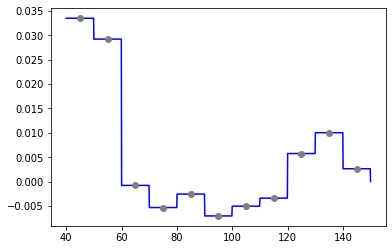

In [15]:
rbins_avg = 0.5*(rbins[1:]+rbins[:-1])
plt.plot(rcont, xi_proj, color='blue')
plt.plot(rbins_avg, xi_ls, marker='o', color='grey', ls='None')

# Quadratic spline on theory data

In [62]:
order = 2 # for quadratic
proj_type = 'generalr'
projfn = 'quadratic_spline.  dat'
# The spline routine writes to file, so remember to delete later
spline.write_bases(rbins[0], rbins[-1], len(rbins)-1, order, projfn)

'quadratic_spline.dat'

Check out basis functions:

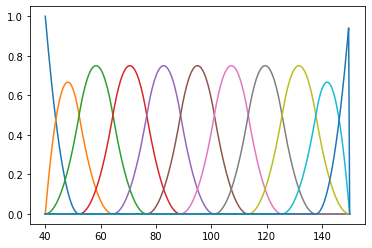

In [63]:
bases = np.loadtxt(projfn)
bases.shape
r = bases[:,0]
for i in range(1, len(bases[0])):
    plt.plot(r, bases[:,i])

In [7]:
# projection
rbins = None
_, dd_proj, _ = DDsmu(1, nthreads, rbins, mumax, nmubins, x, y, z,
                proj_type=proj_type, nprojbins=nbins, projfn=projfn,
                verbose=verbose, boxsize=boxsize, periodic=periodic)

_, dr_proj, _ = DDsmu(0, nthreads, rbins, mumax, nmubins, 
                x, y, z, X2=x_rand, Y2=y_rand, Z2=z_rand, 
                proj_type=proj_type, nprojbins=nbins, projfn=projfn,
                verbose=verbose,
                weights1=weights, weights2=weights_rand, weight_type=weight_type, periodic=periodic)

_, rr_proj, qq_proj = DDsmu(1, nthreads, rbins, mumax, nmubins, x_rand, y_rand, z_rand,
                proj_type=proj_type, nprojbins=nbins, projfn=projfn,
                verbose=verbose,
                weights1=weights_rand, weight_type=weight_type, periodic=periodic)

NameError: name 'projfn' is not defined

In [19]:
amps = compute_amps(nbins, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, qq_proj)
xi_proj = evaluate_xi(nbins, amps, len(rcont), rcont, len(rbins)-1, rbins, proj_type, projfn=projfn)

Computing amplitudes (Corrfunc/utils)
Evaluating xi (Corrfunc/utils)
Reading in projection file, quadratic_spline.dat...
Read in 300 by 12 basis data


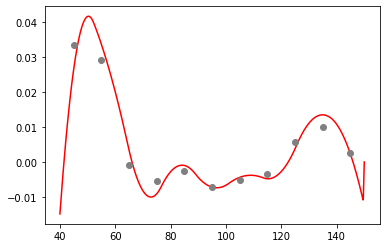

In [20]:
plt.plot(rcont, xi_proj, color='red')
plt.plot(rbins_avg, xi_ls, marker='o', color='grey', ls='None')

Clean up basis function file

In [21]:
os.remove(projfn)

# Periodic box

For a periodic box, we can compute the RR term analytically, so we just need the DD projection.

In [11]:
#proj_type = 'tophat'

order = 2 # for quadratic
proj_type = 'generalr'
projfn = 'quadratic_spline.dat'
# The spline routine writes to file, so remember to delete later
spline.write_bases(rbins[0], rbins[-1], len(rbins)-1, order, projfn)

'quadratic_spline.dat'

In [12]:
_, dd_proj, _ = DDsmu(1, nthreads, rbins, mumax, nmubins, x, y, z,
                proj_type=proj_type, nprojbins=nbins, projfn=projfn,
                verbose=verbose, boxsize=boxsize, periodic=True)

Applying projection requires fallback method, switching instruction set
Reading in projection file, quadratic_spline.dat...
Read in 300 by 17 basis data


The analytic RR term can be computed for component $i$ as:
$$ RR_i = N_D * V_i * \bar{\rho} $$
where
$$ \bar{\rho} = \frac{N_D - 1}{L^3} $$
The $-1$ is because we don't include the galaxy itself when computing it's pairs (i.e. number of pairs for N points is N(N-1)).

In [13]:
volume = boxsize**3
sbins = rbins
nsbins = len(rbins)-1
nprojbins = nbins
qq_ana = qq_analytic(rmin, rmax, nd, volume, nprojbins, nsbins, sbins, proj_type, projfn=projfn)
amps_periodic_ana = np.matmul(np.linalg.inv(qq_ana), dd_proj) - 1
xi_periodic_ana = evaluate_xi(nbins, amps_periodic_ana, len(rcont), rcont, len(rbins)-1, rbins, proj_type, projfn=projfn)

Evaluating xi (Corrfunc/utils)
qq analytic
Reading in projection file, quadratic_spline.dat...
Read in 300 by 17 basis data
Evaluating xi (Corrfunc/utils)
Reading in projection file, quadratic_spline.dat...
Read in 300 by 17 basis data


Compare to theoretical DD(r):

In [9]:
xi_3d_res = xi(boxsize, nthreads, rbins, x, y, z)
xi_3d = np.array([x[3] for x in xi_3d_res], dtype=float)

Try with estimator:

xi(s, mu) with mumax = 1 and 1 mubin should be equiv to xi(r)

For randoms let's load in our bigger box for better convergence:

In [14]:
boxsize = 750
nbar_str_big = '1e-4'
cat_tag_big = '_L{}_nbar{}'.format(boxsize, nbar_str_big)
cat_dir_big = '../byebyebias/catalogs/cats_lognormal{}'.format(cat_tag_big)

# randoms
rand_fn_big = '{}/rand{}_10x.dat'.format(cat_dir_big, cat_tag_big)
random_big = np.loadtxt(rand_fn_big)
x_rand_big, y_rand_big, z_rand_big = random_big.T
nr_big = random_big.shape[0]
#weights_rand = np.full(nr, 0.5)
weights_rand_big = None

In [15]:
# projection
#proj_type = 'tophat'
#proj_type = 'piecewise'
#projfn = None
_, dd_proj, _ = DDsmu(1, nthreads, rbins, mumax, nmubins, x, y, z,
                proj_type=proj_type, nprojbins=nbins, projfn=projfn,
                verbose=verbose, boxsize=boxsize, periodic=True)

_, dr_proj_big, _ = DDsmu(0, nthreads, rbins, mumax, nmubins, 
                x, y, z, X2=x_rand_big, Y2=y_rand_big, Z2=z_rand_big, 
                proj_type=proj_type, nprojbins=nbins, projfn=projfn,
                verbose=verbose,
                weights1=weights, weights2=weights_rand_big, weight_type=weight_type, periodic=True)

_, rr_proj_big, qq_proj_big = DDsmu(1, nthreads, rbins, mumax, nmubins, x_rand_big, y_rand_big, z_rand_big,
                proj_type=proj_type, nprojbins=nbins, projfn=projfn,
                verbose=verbose,
                weights1=weights_rand_big, weight_type=weight_type, periodic=True)

Applying projection requires fallback method, switching instruction set
Reading in projection file, quadratic_spline.dat...
Read in 300 by 17 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, quadratic_spline.dat...
Read in 300 by 17 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, quadratic_spline.dat...
Read in 300 by 17 basis data


In [16]:
amps_big = compute_amps(nbins, nd, nd, nr_big, nr_big, dd_proj, dr_proj_big, dr_proj_big, rr_proj_big, qq_proj_big)
xi_proj_big = evaluate_xi(nbins, amps_big, len(rcont), rcont, len(rbins)-1, rbins, proj_type, projfn=projfn)

Computing amplitudes (Corrfunc/utils)
Evaluating xi (Corrfunc/utils)
Reading in projection file, quadratic_spline.dat...
Read in 300 by 17 basis data


In [17]:
_, dr_proj, _ = DDsmu(0, nthreads, rbins, mumax, nmubins, 
                x, y, z, X2=x_rand, Y2=y_rand, Z2=z_rand, 
                proj_type=proj_type, nprojbins=nbins, projfn=projfn,
                verbose=verbose,
                weights1=weights, weights2=weights_rand, weight_type=weight_type, periodic=True)

_, rr_proj, qq_proj = DDsmu(1, nthreads, rbins, mumax, nmubins, x_rand, y_rand, z_rand,
                proj_type=proj_type, nprojbins=nbins, projfn=projfn,
                verbose=verbose,
                weights1=weights_rand, weight_type=weight_type, periodic=True)

amps = compute_amps(nbins, nd, nd, nr, nr, dd_proj, dr_proj, dr_proj, rr_proj, qq_proj)
xi_proj = evaluate_xi(nbins, amps, len(rcont), rcont, len(rbins)-1, rbins, proj_type, projfn=projfn)

Applying projection requires fallback method, switching instruction set
Reading in projection file, quadratic_spline.dat...
Read in 300 by 17 basis data
Applying projection requires fallback method, switching instruction set
Reading in projection file, quadratic_spline.dat...
Read in 300 by 17 basis data
Computing amplitudes (Corrfunc/utils)
Evaluating xi (Corrfunc/utils)
Reading in projection file, quadratic_spline.dat...
Read in 300 by 17 basis data


The discrepancy at high-r is because there are fewer points there so we can't reach the theoretical (true) answer.

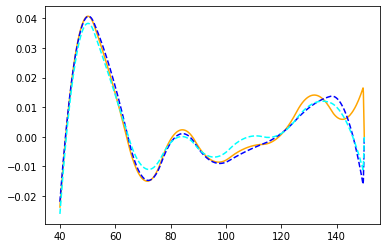

In [30]:
plt.plot(rcont, xi_periodic_ana, color='orange', ls='-')
#plt.plot(rbins_avg, xi_3d, marker='d', color='magenta', ls='None')
plt.plot(rcont, xi_proj_big, color='blue', ls='--')
plt.plot(rcont, xi_proj, color='cyan', ls='--')

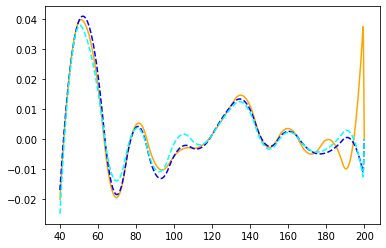

In [18]:
plt.plot(rcont, xi_periodic_ana, color='orange', ls='-')
#plt.plot(rbins_avg, xi_3d, marker='d', color='magenta', ls='None')
plt.plot(rcont, xi_proj_big, color='blue', ls='--')
plt.plot(rcont, xi_proj, color='cyan', ls='--')

## Periodic tophat

In [9]:
proj_type = 'tophat'
projfn = None
_, dd_proj, _ = DDsmu(1, nthreads, rbins, mumax, nmubins, x, y, z,
                proj_type=proj_type, nprojbins=nbins, projfn=projfn,
                verbose=verbose, boxsize=boxsize, periodic=True)

Applying projection requires fallback method, switching instruction set


In [10]:
volume = boxsize**3
sbins = rbins
nsbins = len(rbins)-1
nprojbins = nbins
qq_ana = qq_analytic(rmin, rmax, nd, volume, nprojbins, nsbins, sbins, proj_type, projfn=projfn)
amps_periodic_ana = np.matmul(np.linalg.inv(qq_ana), dd_proj) - 1
xi_periodic_ana = evaluate_xi(nbins, amps_periodic_ana, len(rcont), rcont, len(rbins)-1, rbins, proj_type, projfn=projfn)

Evaluating xi (Corrfunc/utils)
qq analytic


ValueError: too many values to unpack (expected 2)

In [ ]:
#!jupyter nbconvert --to script example.ipynb